In [1]:
import h5py, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

In [2]:
import sys; sys.path.append("../../offline/")
import sparse, geom, utils

In [3]:
path_to_data = "../../data/sparse/" # scratch/sparse on Maxwell
path_to_aux = "../../data/aux/" # scratch/benedikt/aux on Maxwell
path_to_geometry = "../../geometry/"
path_to_recons = "../../data/recons/"

## Load detector file from 2160

In [4]:
emc_detector = path_to_recons + "det/det_2160_lowq7.h5"
with h5py.File(emc_detector, "r") as f:
    mask = f['mask'][:].reshape((4,128,128))
new_mask = mask.copy()

## Include bad-pixels (identified during 2DEMC classification)

In [5]:
# from cell 1
new_mask[0,107:108+1,16:107+1] = 2
new_mask[0,109,106] = 2
new_mask[0,109,108] = 2
new_mask[0,114,109] = 2
new_mask[0,116,108] = 2
new_mask[0,120,107] = 2
new_mask[0,123,104] = 2
new_mask[0,125,103] = 2
new_mask[0,125,106] = 2

In [6]:
# from cell 2
new_mask[3,125,57:58+1] = 2
new_mask[3,126,58:59+1] = 2
new_mask[3,124,42] = 2
new_mask[3,122,41:42+1] = 2
new_mask[3,114:118+1,37] = 2
new_mask[3,114:117+1,36] = 2
new_mask[3,115,35] = 2
new_mask[3,111,35] = 2
new_mask[3,109,34:36+1] = 2
new_mask[3,106:108+1,33:36+1] = 2
new_mask[3,105,34] = 2

In [7]:
# from cell 12
new_mask[3,110,35] = 2
new_mask[3,90,27] = 2
new_mask[3,68,40] = 2
new_mask[3,20,67] = 2
new_mask[3,34,116] = 2
new_mask[3,105,103] = 2

In [8]:
# bright outliers
new_mask[1,27,34] = 2
new_mask[1,45,47] = 2
new_mask[0,112,105]  = 2

In [9]:
# more bad-pixels
new_mask[1,122,20:23] = 2
new_mask[1,124,20:23] = 2

In [10]:
# Halo from direct beam
new_mask[1,124,1:10] = 2
new_mask[1,125,1:12] = 2
new_mask[1,126,1:14] = 2

## Plot new mask

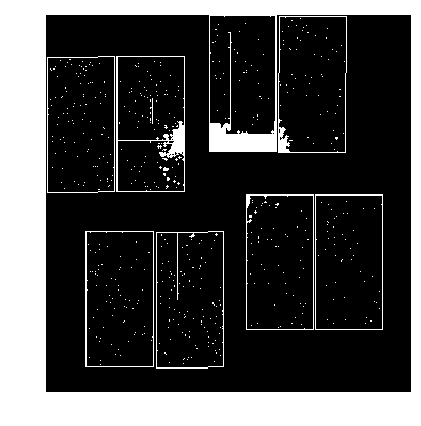

In [11]:
plt.figure(figsize=(5,5), dpi=100)
plt.axis('off')
plt.imshow(utils.assemble(np.transpose(new_mask, axes=(0,2,1)), path_to_geometry + "b2_lowq.geom"), cmap='gray')
plt.savefig("../../plots/lowq_mask1.png", bbox_inches='tight')
plt.show()

## Save mask in new detector file (version 1)

In [12]:
new_detector = path_to_recons + "det/det_2145_lowq1.h5"
os.system("cp %s %s" %(emc_detector, new_detector))
with h5py.File(new_detector, "a") as f:
    f['mask'][:] = new_mask.ravel()

## Include statistical outliers from long dark (run 597)

In [13]:
masks = []
for m in range(16):
    with h5py.File(path_to_recons + 'det/r0597/r0597_AGIPD%02d_v01_mask.h5' %m, 'r') as f:
        masks.append(np.bool8(f['mask'][:]))
masks = np.array(masks)
combined_mask = np.transpose(masks.all(axis=1),axes=(0,2,1))

In [14]:
new_mask[0][combined_mask[3, :,-128:]==0] = 2
new_mask[1][combined_mask[4, :,-128:]==0] = 2
new_mask[2][combined_mask[8, :,-128:]==0] = 2
new_mask[3][combined_mask[15,:,-128:]==0] = 2

## Plot new mask

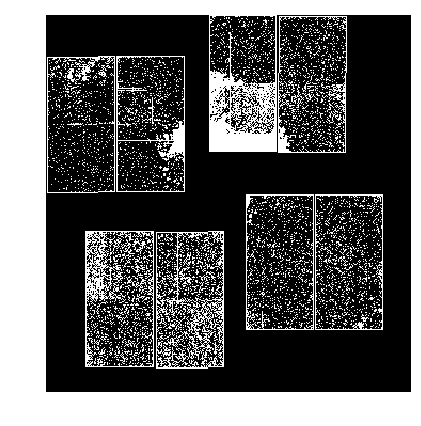

In [15]:
plt.figure(figsize=(5,5), dpi=100)
plt.axis('off')
plt.imshow(utils.assemble(np.transpose(new_mask, axes=(0,2,1)), path_to_geometry + "b2_lowq.geom"), cmap='gray')
plt.savefig("../../plots/lowq_mask2.png", bbox_inches='tight')
plt.show()

## Save mask in new detector file (version 2)

In [16]:
new_detector = path_to_recons + "det/det_2145_lowq2.h5"
os.system("cp %s %s" %(emc_detector, new_detector))
with h5py.File(new_detector, "a") as f:
    f['mask'][:] = new_mask.ravel()